In [1]:
# importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# load dataset from SHRS_smallDS.xlsx
df = pd.read_csv('bladder.csv',index_col=False)

In [2]:
df.shape

(19207, 26)

In [3]:
cancer_type_df = df[['age',
                    # 'gender_code',
                    # ' behaviour_code',
                    'cs_extension_code',
                    # 'grade_code10',
                    'histologic_type_code',
                    'cs_lymph_nodes_code',
                    # 'marital_status_code',
                    'cs_mets_at_dx_code',
                    'primary_site_code7',
                    # 'race_code',
                    # ' radiation_code',
                    ' number_of_nodes_examined',
                    ' regional_positive_nodes ',
                    # 'number_of_primaries',
                    ' site_specific_surgery_code',
                    'stage_of_cancer_code',
                    'cs_tumor_size',
                    'survived_code ']]

cancer_type_df.head()

,age,cs_extension_code,histologic_type_code,cs_lymph_nodes_code,cs_mets_at_dx_code,primary_site_code7,number_of_nodes_examined,regional_positive_nodes,site_specific_surgery_code,stage_of_cancer_code,cs_tumor_size,survived_code
0,77,30,8130,0,0,C678,0,98,27,0,50,yes
1,50,30,8130,0,0,C672,0,98,27,0,20,yes
2,75,10,8130,0,0,C679,0,98,27,0,21,yes
3,41,411,8070,0,0,C678,0,98,30,2,40,no
4,49,10,8130,0,0,C672,0,98,27,0,20,yes


In [4]:
# Pre-processing
cancer_type_df = cancer_type_df.dropna()

cancer_type_df['survived_code '] = cancer_type_df['survived_code '].map({'yes': 1, 'no': 0})
cancer_type_df['primary_site_code7'] = cancer_type_df['primary_site_code7'].str[1:]
cancer_type_df['primary_site_code7'] = pd.to_numeric(cancer_type_df['primary_site_code7'], errors='raise')

cancer_type_df['stage_of_cancer_code'] = cancer_type_df['stage_of_cancer_code'].replace(" ", np.NAN)  # Replace with np.NAN or other value

cancer_type_df = cancer_type_df.dropna(subset=['stage_of_cancer_code'])  # Drop rows with NaN in 'stage_of_cancer_code'

# Try converting 'stage_of_cancer_code' to numeric, handling potential errors
try:
      cancer_type_df['stage_of_cancer_code'] = pd.to_numeric(cancer_type_df['stage_of_cancer_code'], errors='raise')
except ValueError:
      print("Error: Some values in 'stage_of_cancer_code' cannot be converted to numeric (after removing empty strings).")

cancer_type_df.shape

(19207, 12)

In [5]:
cancer_type_stage_df = cancer_type_df[cancer_type_df['stage_of_cancer_code'] == 1]
cancer_type_stage_df.shape

(6851, 12)

In [6]:
from sklearn.model_selection import train_test_split
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# separate array into input and output components
X = cancer_type_stage_df.drop(['survived_code ', 'stage_of_cancer_code'], axis=1)
y = cancer_type_stage_df['survived_code ']

(X_train, X_test,
 y_train, y_test) = train_test_split(X, y, train_size=0.8, random_state=42)

# Logistic Regression

In [7]:
# Without fairness
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
lr_acc = accuracy_score(y_test, y_pred)
lr_acc

0.7826404084609774

In [8]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation with accuracy scoring
scores = cross_val_score(lr, X, y, cv=5, scoring='accuracy')

# Print the average accuracy across folds
print("Average Accuracy:", scores.mean())

Average Accuracy: 0.7720046638662174


In [9]:
# import shap and data visualization tool
import shap
import matplotlib.pyplot as plt

# load JS visualization code to notebook
shap.initjs()

# Create the explainer for unmitigated model
lr_unmitigated_explainer = shap.Explainer(lr.predict, X_train)
lr_unmitigated_shap_values = lr_unmitigated_explainer(X_test)

Logistic Regression Variable Importance Plot - Global Interpretation


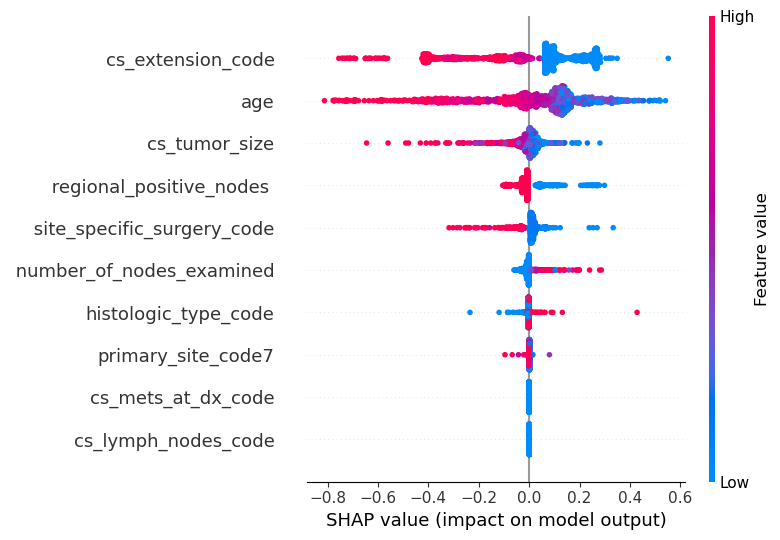

In [10]:
print("Logistic Regression Variable Importance Plot - Global Interpretation")
figure = plt.figure()
shap.summary_plot(lr_unmitigated_shap_values, X_test)

# Decision Tree

In [11]:
# Without fairness
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
dt_acc = accuracy_score(y_test, y_pred)
dt_acc

0.6885485047410649

In [12]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation with accuracy scoring
scores = cross_val_score(dt, X, y, cv=5, scoring='accuracy')

# Print the average accuracy across folds
print("Average Accuracy:", scores.mean())

Average Accuracy: 0.7010669392579342


Decision Tree Variable Importance Plot - Global Interpretation


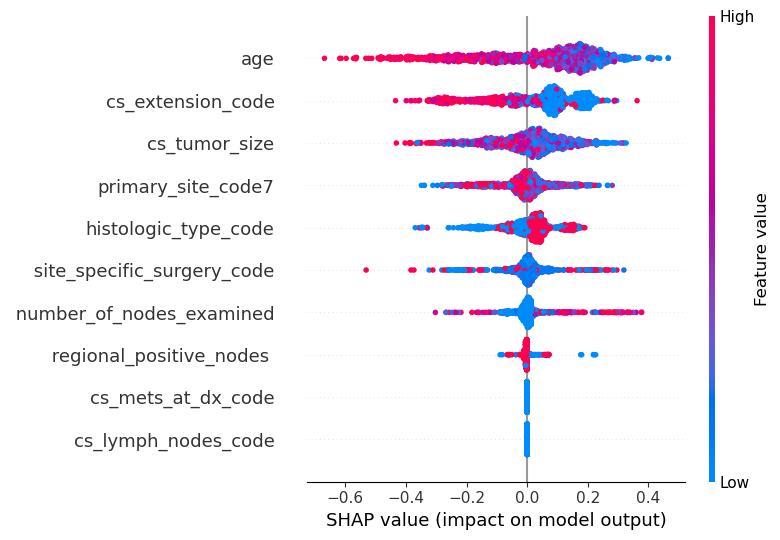

In [11]:
# import shap and data visualization tool
import shap
import matplotlib.pyplot as plt

# load JS visualization code to notebook
shap.initjs()

# Create the explainer
dt_unmitigated_explainer = shap.Explainer(dt.predict, X_train)
dt_unmitigated_shap_values = dt_unmitigated_explainer(X_test)
print("Decision Tree Variable Importance Plot - Global Interpretation")
figure = plt.figure()
shap.summary_plot(dt_unmitigated_shap_values, X_test)

# AdaBoost

In [13]:
# Without fairness
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)
ada_acc = accuracy_score(y_test, y_pred)
ada_acc

0.7979576951130561

In [14]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation with accuracy scoring
scores = cross_val_score(ada, X, y, cv=5, scoring='accuracy')

# Print the average accuracy across folds
print("Average Accuracy:", scores.mean())

Average Accuracy: 0.7927327806971309


ExactExplainer explainer: 1372it [00:48, 22.48it/s]                                                              


AdaBoost Variable Importance Plot - Global Interpretation


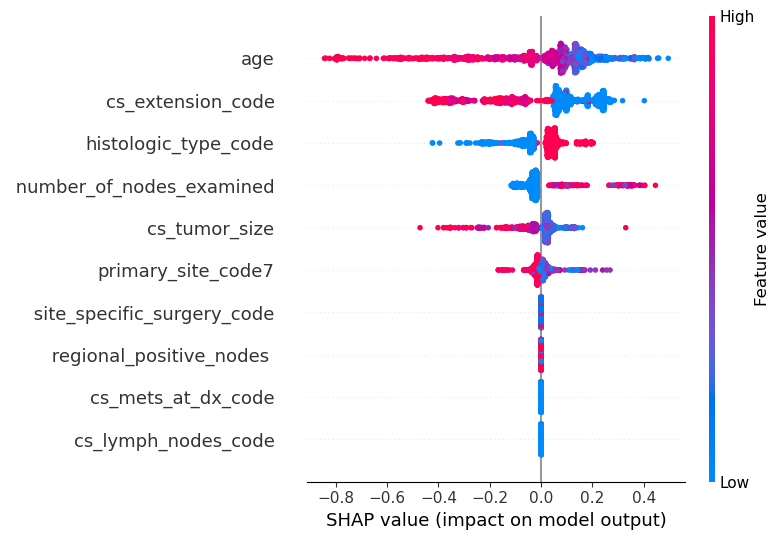

In [13]:
# import shap and data visualization tool
import shap
import matplotlib.pyplot as plt

# load JS visualization code to notebook
shap.initjs()

ada_unmitigated_explainer = shap.Explainer(ada.predict, X_train)
ada_unmitigated_shap_values = ada_unmitigated_explainer(X_test)

print("AdaBoost Variable Importance Plot - Global Interpretation")
figure = plt.figure()
shap.summary_plot(ada_unmitigated_shap_values, X_test)

# XGBoost

In [15]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
xgb_acc = accuracy_score(y_test, y_pred)
xgb_acc

0.7935813274981766

In [16]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation with accuracy scoring
scores = cross_val_score(xgb, X, y, cv=5, scoring='accuracy')

# Print the average accuracy across folds
print("Average Accuracy:", scores.mean())

Average Accuracy: 0.7803241280540071


ExactExplainer explainer: 1372it [00:11, 11.83it/s]                                                              


XGBoost Variable Importance Plot - Global Interpretation


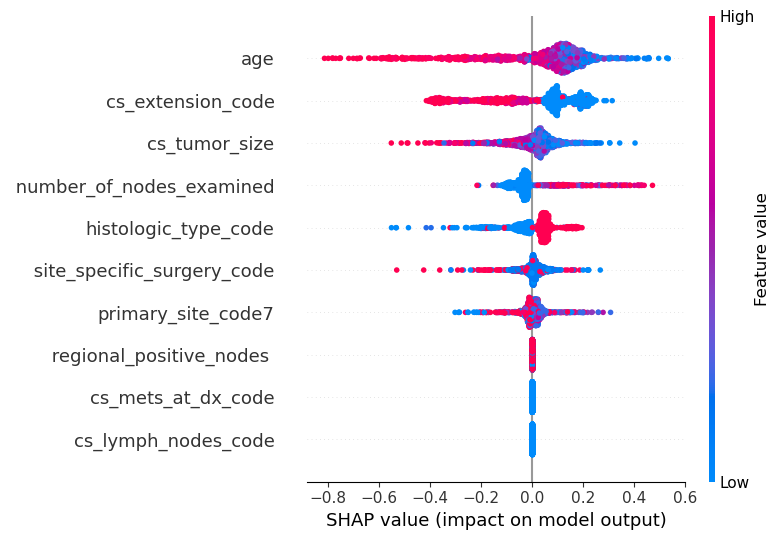

In [15]:
# import shap and data visualization tool
import shap
import matplotlib.pyplot as plt

# load JS visualization code to notebook
shap.initjs()

# Create the explainer for unmitigated model
xgb_unmitigated_explainer = shap.Explainer(xgb.predict, X_train)

# Calculate SHAP values for the subset
xgb_unmitigated_shap_values = xgb_unmitigated_explainer(X_test)

print("XGBoost Variable Importance Plot - Global Interpretation")
figure = plt.figure()
shap.summary_plot(xgb_unmitigated_shap_values, X_test)